In [163]:
%matplotlib inline
import io
import pickle


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


def process(data_string):
    try:
        return np.array(
            data_string.replace('\n', '').strip().split(' '), 
            dtype=np.longdouble
        )
    except ValueError:
        return ''

def get_data(verbose=False):
    with io.FileIO('ex3data1.dat') as file:
        for _ in range(5):
            line = file.readline()
            if verbose:
                print line
        data = [process(line) for line in file]
        disguard1 = data.pop()
        disguard2 = data.pop()
        return np.array(data), disguard1, disguard2


def pickle_data(data):
    with open('ex3data1_py.dat', 'w') as file:
        s = pickle.dumps(data)
        file.write(s)
        
data128, d1, d2 = get_data()
assert not d1
assert not d2
assert data128.shape == (5000, 400)
        
def transpose():
    """ Likely because Octave is column-major and numpy is row-major, each image when loaded is transposed. """
    m, n = data128.shape
    assert n == 400
    for index, row in enumerate(data128):
        transposed = row.reshape(20, 20).T.reshape(1, n)
        # assert transposed != row
        data128[index, :] = transposed
transpose()
    
print 'done'

done


In [11]:
def get_labels():
    with io.FileIO('y.dat') as file:
        return np.array([np.int(float(line)) for line in file.readlines()])
        
y0 = get_labels()
y = y0.copy()    
# Octave uses 1-indexing, so to prevent confusion, MNIST '0's were labelled as '10'. 
y[y == 10] = 0

# Logistic regression cost functions:

In [216]:
from scipy.optimize import minimize

sigmoid = lambda z: 1/(1 + np.power(np.e, -z))
h = lambda theta, x: sigmoid(x.dot(theta))
h_log = lambda theta, x: log_sigmoid(x.dot(theta))

def log_sigmoid(z):
    m = np.max(z)
    normalized = z - m 
    return -np.log1p(m + np.log(np.exp(-normalized)))

def cost(theta, X, y, debug, lambd=0, **kwargs):
    """ Logistic regression cost function with optional regularization. `Lambd` is the regularization constant. """
    m = X.shape[0]
    j = y.dot(np.log(h(theta, X)))  + (1 - y).dot(np.log(1 - h(theta, X)))
    regularization = (float(lambd)/float(2*m)) * theta[1:].dot(theta[1:].T)
    if debug:
        print 'MAX: x.dot(theta): %s' % np.max(X.dot(theta))
        print 'h(x) = %s' % h(theta, X)
        # print 'log hypothesis: %s' % np.log(h(theta, X))
        # print '======================='
        
    j /= -m
    j += regularization
    return j


def grad(theta, X, y, lambd=0, **kwargs):
    m = X.shape[0]
    regularization_theta = theta.copy()
    regularization_theta[0] = 0
    return ((h(theta, X) - y).dot(X))/m + (float(lambd)/m)*regularization_theta.astype(float)

def check_functions(grad_func, cost_func):
    '''
    Asserts that the cost and gradient functions return known corret values for a given theta, X, y.  
    Test case from https://www.coursera.org/learn/machine-learning/discussions/weeks/3/threads/tA3ESpq0EeW70BJZtLVfGQ
    The expected cost is 4.6832.
    The expected gradient = [0.31722, 0.87232, 1.64812, 2.23787]
    '''
    test_X = np.array([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])  # X
    test_y = np.array([[1, 0, 1]])  # y
    test_theta = np.array([-2, -1, 1, 2])
    
    grad_diff = grad_func(test_theta, test_X, test_y) - np.array([0.31722, 0.87232, 1.64812, 2.23787])
    assert grad_diff.dot(grad_diff.T) < 0.0001
    assert abs(cost_func(test_theta, test_X, test_y, debug=False) - 4.6832) < 0.0001
    
check_functions(grad, cost)


In [217]:
k = len(set(y))  # num of classes, in this case the digits '0' thru '9'
m, features = data128.shape
X = data128.copy()
Theta = np.zeros((k, features + 1))
initial_theta = np.zeros(features+1)

def scale_features(X_input, debug=False):
    X = X_input.copy()
    features = X.shape[1]
    for column in range(features):
        X[:, column] -= X[:, column].mean()
        if X[:, column].std() != 0:
            X[:, column] /= X[:, column].std()
    return X

# Slice out one of the digit classes:
def get_data_slice(scale=False, debug=False, test_class=0):
    X_0 = X.copy()
    if scale:
        X_0 = scale_features(X, debug=True)
    X_0 = X_0[y==test_class, :]
    y_0 = y[y==test_class]
    return X_0, y_0

debug=True

X_0, y_0 = get_data_slice(scale=True, debug=debug, test_class=2)
X_1 = np.concatenate([np.ones((X_0.shape[0], 1)), X_0], axis=1)
assert X_1.shape[1] == 401

def regularized_cost(theta, X, y, debug): return cost(theta, X, y, lambd=0.1, debug=debug)
def regularized_grad(theta, X, y, debug): return grad(theta, X, y, lambd=0.1, debug=debug)

minimization_result = minimize(
    fun=regularized_cost, 
    x0=initial_theta, 
    args=(X_1, y_0, debug), 
    jac=regularized_grad,
    options={'disp': True}
)
Theta[test_class, :] = minimization_result.x

def train():
    scale_features(X)
    for klass in range(k):
        result = minimize(fun=cost, x0=initial_theta, args=(X[y==klass, :], y[y==klass], False), jac=grad)
        if result.success:
            Theta[klass, :] = result.x
        else:
            print "Failed for %s" % klass
# train()
print minimization_result.success
print 'done!'
# print minimization_result.x

MAX: x.dot(theta): 0.0
h(x) = [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0

/Users/liavkoren/Envs/data-sci/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


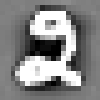

In [208]:
from PIL import Image
from numpy import interp
from IPython.display import display


# A feature scaled image: 
def row2image(row):
    img = interp(np.float64(row), [-1, 1], [0, 1])
    img *= 255
    image = Image.fromarray(img.reshape((20, 20))).convert('RGB')
    return image.resize((100, 100))

img = row2image(X_1[499, 1:])
img


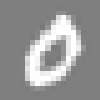

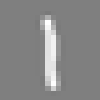

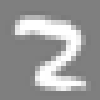

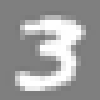

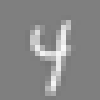

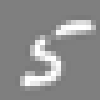

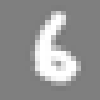

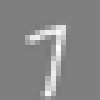

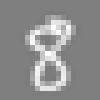

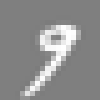

In [207]:
# The raw data:
    
for index in range(3, 5000, 500):
    row = data128[index, :]
    display(row2image(row))


In [165]:
print 'done'

done


In [131]:
np.log1p

In [162]:
def process(data_string):
    try:
        return np.array(
            data_string.replace('\n', '').strip().split(','), 
            dtype=np.int
        )
    except ValueError:
        return ''

def get_test_data(verbose=False):
    with io.FileIO('small_test.dat') as file:
        data = [process(line) for line in file]
        return np.array(data)
test = get_test_data()
print test.T.reshape(1, 16).reshape(4, 4)
for index, row in enumerate(test):
    print '%s %s' % (index, row)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
0 [ 1  5  9 13]
1 [ 2  6 10 14]
2 [ 3  7 11 15]
3 [ 4  8 12 16]
